# import dataset

### Load dataset

In [ ]:
from datasets import load_dataset
#dataset = load_dataset("SLPRL-HUJI/HebDB", "YV_pre", cache_dir='datasets')

dataset = load_dataset("SLPRL-HUJI/HebDB", "YV_pre", streaming=False, cache_dir='datasets')
dataset = dataset['train']

Resolving data files:   0%|          | 0/608 [00:00<?, ?it/s]

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000218270E1A80>>
Traceback (most recent call last):
  File "D:\Documents\GitHub\Audio-Project\.venv\lib\site-packages\ipykernel\ipkernel.py", line 788, in _clean_thread_parent_frames
    if phase != "start":
KeyboardInterrupt: 

KeyboardInterrupt



### Save dataset

In [25]:
dataset.save_to_disk("data")

Saving the dataset (0/31 shards):   0%|          | 0/45472 [00:00<?, ? examples/s]

### Load dataset from disk

In [6]:
from datasets import load_from_disk
dataset = load_from_disk("data")

Loading dataset from disk:   0%|          | 0/31 [00:00<?, ?it/s]

### Take a look at the dataset

In [7]:
dataset.features

{'fname': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None),
 'n_samples': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 'normalized_text': Value(dtype='string', id=None),
 'score': Value(dtype='float64', id=None),
 'raw': {'end_sec': Value(dtype='float64', id=None),
  'fname': Value(dtype='string', id=None),
  'start_sec': Value(dtype='float64', id=None)},
 'is_raw': Value(dtype='bool', id=None),
 'source': Value(dtype='string', id=None)}

In [3]:
print(dataset.take(1))

Dataset({
    features: ['fname', 'audio', 'n_samples', 'text', 'normalized_text', 'score', 'raw', 'is_raw', 'source'],
    num_rows: 1
})


In [4]:
dataset[42000]

{'fname': '11352318_end-index-1201.wav',
 'audio': {'path': '92fffdc8b2f0c982d8a055323fea5c02d8f3a8be13e2dff5d9c28febea68e01f',
  'array': array([-0.08934021, -0.08877563, -0.08435059, ..., -0.00022888,
          0.        ,  0.00033569]),
  'sampling_rate': 16000},
 'n_samples': 139200,
 'text': 'ממש. לא, אני כמעט ולא זוכר, כמעט ולא זוכר, אלה היו כבר בגילאים כאלה, שלי לא היה כל קשר',
 'normalized_text': 'ממש לא אני כמעט ולא זוכר כמעט ולא זוכר אלה היו כבר בגילאימ כאלה שלי לא היה כל קשר',
 'score': 0.2206652193332452,
 'raw': {'end_sec': None, 'fname': None, 'start_sec': None},
 'is_raw': False,
 'source': 'Yad_vashem'}

---
# Preprocessing

In [ ]:
### Remove empty rows

In [ ]:
def is_text(text):
    # Filter out examples without text (text is empty or None)
    return text is not None and len(text) > 0

dataset = dataset.filter(is_text, input_columns="normalized_text")

In [ ]:
def is_audio(audio):
    # Filter out examples without audio (audio is empty or None)
    return audio["array"] is not None and len(audio["array"]) > 0

dataset = dataset.filter(is_audio, input_columns="audio")

### Tokenization

In [7]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')

In [8]:
labels = tokenizer(dataset[0]["normalized_text"]).input_ids
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)
print(dataset[0]["normalized_text"])
print(decoded_str)

NotImplementedError: Subclasses of Dataset should implement __getitem__.

In [11]:
def tokenization(examples):
    return tokenizer(examples["normalized_text"], padding="max_length")

In [17]:
dataset_pre = dataset.map(tokenization, batched=True)

In [18]:
for i in range(100):
    print(len(dataset_pre[i]["input_ids"]))

NotImplementedError: Subclasses of Dataset should implement __getitem__.

### MFCC

In [12]:
# listen to the audio
import IPython.display as ipd
i = 998
ipd.Audio(dataset[i]["audio"]["array"], rate=dataset[i]["audio"]["sampling_rate"])

In [14]:
from datasets import Audio
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

In [19]:
from transformers import WhisperFeatureExtractor
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [26]:
def feature_extraction(example, feature_extractor):
    audio = example["audio"]
    example["mfcc"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    return example

In [27]:
dataset_pre2 = dataset.take(30).map(feature_extraction, fn_kwargs={"feature_extractor": feature_extractor},
                            batched=False)

In [28]:
dataset_pre2 = dataset_pre2.with_format("torch")
for i in range(30):
    print(dataset_pre2[i]["mfcc"].shape)

torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])
torch.Size([80, 3000])


In [29]:
dataset_pre2.features

{'fname': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'n_samples': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 'normalized_text': Value(dtype='string', id=None),
 'score': Value(dtype='float64', id=None),
 'raw': {'end_sec': Value(dtype='float64', id=None),
  'fname': Value(dtype='string', id=None),
  'start_sec': Value(dtype='float64', id=None)},
 'is_raw': Value(dtype='bool', id=None),
 'source': Value(dtype='string', id=None),
 'mfcc': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None)}

### Remove columns

In [32]:
dataset_pre3 = dataset_pre2.remove_columns(["audio", "fname", "text", "score", "raw", "is_raw", "source", "n_samples"])
dataset_pre3.features

{'normalized_text': Value(dtype='string', id=None),
 'mfcc': Sequence(feature=Sequence(feature=Value(dtype='float32', id=None), length=-1, id=None), length=-1, id=None)}

### torch

In [ ]:
dataset_pre2 = dataset_pre2.with_format("torch")

### plot

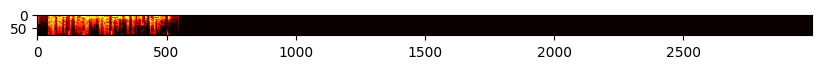

In [41]:
#plot the mfcc
import matplotlib.pyplot as plt
import numpy as np

mfcc = dataset_pre2[0]["input_features"]
plt.figure(figsize=(10, 4))
plt.imshow(mfcc, cmap='hot', interpolation='nearest')
plt.show()

### Format

In [56]:
dataset_pre = dataset_pre.with_format("torch")

In [57]:
dataset_pre.features

{'fname': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=None, mono=True, decode=True, id=None),
 'n_samples': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 'normalized_text': Value(dtype='string', id=None),
 'score': Value(dtype='float64', id=None),
 'raw': {'end_sec': Value(dtype='float64', id=None),
  'fname': Value(dtype='string', id=None),
  'start_sec': Value(dtype='float64', id=None)},
 'is_raw': Value(dtype='bool', id=None),
 'source': Value(dtype='string', id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

---
# StreamDataset

In [12]:
import os

input_dir = r"""datasets\SLPRL-HUJI___heb_db\YV_pre\0.0.0\cb51d1ccacba7cb1b85483f29495cfc824a71148"""
arrow_files = [os.path.join(root, f) for root, _, filenames in os.walk(input_dir) for f in filenames if f.endswith(".arrow")]

In [13]:
from datasets import Dataset

reader = Dataset.from_file(arrow_files[0])

In [14]:
x = 1

KeyboardInterrupt: 

In [ ]:
from litdata import optimize

optimize(
    fn=tokenization,
    inputs=arrow_files[0:2],
    output_dir="/data_fast",
    chunk_bytes="64MB"
)

Create an account on https://lightning.ai/ to optimize your data faster using multiple nodes and large machines.
Storing the files under D:\data_fast
Setup started with fast_dev_run=False.
Setup finished in 0.015 seconds. Found 2 items to process.
Starting 1 workers with 2 items. The progress bar is only updated when a worker finishes.
Workers are ready ! Starting data processing...


Progress:   0%|          | 0/2 [00:00<?, ?it/s]

---
# Dataloader

In [9]:
import torch
from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling

In [22]:
dataloader = DataLoader(dataset, collate_fn=DataCollatorForLanguageModeling(tokenizer))

KeyboardInterrupt: 

In [13]:
for batch in dataloader:
    print(batch)
    break

ValueError: You should supply an encoding or a list of encodings to this method that includes input_ids, but you provided ['fname', 'audio', 'n_samples', 'text', 'normalized_text', 'score', 'raw', 'is_raw', 'source']